# regression decoder test (~10/6/22) (FOR FILIPE DATA ONLY)
this compares a fixed decoder, pca decoder, cca transformation (w/ day0 decoder), and a regression decoder on day-N data. the latter two use a day-0 data as a prior start. 

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.cca_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
from src.utils import *
import pickle
import scipy as sio
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
import os
from itertools import cycle, islice
import copy

# set paths/create objects

cp1 = day-0

cp2 = day-n


# patdump
with open('/home/diya/Documents/rat-fes/data/pickles/N5_171001_proc.pkl', 'rb') as inp: #YOUR PATH HERE
    cp1=pickle.load(inp)
    
with open('/home/diya/Documents/rat-fes/data/pickles/N5_171016_proc.pkl', 'rb') as inp: #YOUR PATH HERE
    cp2=pickle.load(inp)
    
with open('/home/diya/Documents/rat-fes/data/pickles/N5_171130_proc.pkl', 'rb') as inp: #YOUR PATH HERE
    cp3=pickle.load(inp)
    
----

with open('/home/diya/Documents/rat-fes/data/pickles/N6_171026_proc.pkl', 'rb') as inp: #YOUR PATH HERE
    cp1=pickle.load(inp)
    
with open('/home/diya/Documents/rat-fes/data/pickles/N6_171204_proc.pkl', 'rb') as inp: #YOUR PATH HERE
    cp2=pickle.load(inp)
    
with open('/home/diya/Documents/rat-fes/data/pickles/N6_171211_proc.pkl', 'rb') as inp: #YOUR PATH HERE
    cp3=pickle.load(inp)
    
----

with open('/home/diya/Documents/rat-fes/data/pickles/N5_mixed.pkl', 'rb') as inp: #YOUR PATH HERE
    cp1 = pickle.load(inp)
with open('/home/diya/Documents/rat-fes/data/pickles/N6_mixed.pkl', 'rb') as inp: #YOUR PATH HERE
    cp2 = pickle.load(inp)
with open('/home/diya/Documents/rat-fes/data/pickles/N9_mixed.pkl', 'rb') as inp: #YOUR PATH HERE
    cp3 = pickle.load(inp)
    
----

with open('/home/diya/Documents/rat-fes/data/pickles/N9_171121_proc.pkl', 'rb') as inp: #YOUR PATH HERE
    cp1=pickle.load(inp)
    
with open('/home/diya/Documents/rat-fes/data/pickles/N9_171204_proc.pkl', 'rb') as inp: #YOUR PATH HERE
    cp2=pickle.load(inp)
    
with open('/home/diya/Documents/rat-fes/data/pickles/N9_171211_proc.pkl', 'rb') as inp: #YOUR PATH HERE
    cp3=pickle.load(inp)


In [2]:
with open('/home/diya/Documents/rat-fes/data/pickles/N5_mixed.pkl', 'rb') as inp: #YOUR PATH HERE
    cp1 = pickle.load(inp)
with open('/home/diya/Documents/rat-fes/data/pickles/N6_mixed.pkl', 'rb') as inp: #YOUR PATH HERE
    cp2 = pickle.load(inp)
with open('/home/diya/Documents/rat-fes/data/pickles/N9_mixed.pkl', 'rb') as inp: #YOUR PATH HERE
    cp3 = pickle.load(inp)

In [3]:
#subsampling list, percent of total data
start = 0.005
step = .005
list1 = np.arange(start, .2, step)
big_step = 0.05
list2 = np.arange(list1[-1]+ big_step, 1, big_step)
subsample_list = [*list1, *list2]
#subsample_list = [0.01, 0.02, 0.1, 1.0]
nummy = cp2.data['rates'][0].shape[0]
#newlist = [int(sub * nummy) for sub in subsample_list]

#print(f'num_samples:{newlist}')
#print(subsample_list)

In [4]:
pca_dims=8

# getting day0 decoder
apply PCA (based on all data), and then train wiener filter.
also get a day0-scaled-weights-decoder

In [5]:
#get day0 decoder weights, scaled + unscaled versions

day0_decoder, nada, naday, nadax = cp1.decode_angles(X=cp1.apply_PCA(dims=pca_dims))
day0_transformer = cp1.pca_object
#lowest_num_dimensions = cp1.num_components
print(nada[1])

X_tempy =cp1.apply_PCA(pca_dims)
scaler = StandardScaler()
X_scale = scaler.fit_transform(np.squeeze(X_tempy))
day0_decoder_scale, nada, naday, nadax = cp1.decode_angles(X=[X_scale])

print(nada[1])

0.728
0.728


# holding out test and train set

In [6]:
percent_data = int(.8 * nummy)
cp2_test = copy.deepcopy(cp2)

cp2.data['rates'] = [cp2.data['rates'][0][:percent_data,:]]
cp2.data['angles'] = [cp2.data['angles'][0][:percent_data,:]]

cp2_test.data['rates']= [cp2_test.data['rates'][0][percent_data:,:]]
cp2_test.data['angles']= [cp2_test.data['angles'][0][percent_data:,:]]

# getting fixed decoder scores
1) we subsample Day-N data, and fit PCA transformation. 
2) we transform entire Day-N data, and decode using Day0 decoder.

# getting PCA decoder scores
1) we subsample Day-N data, fit PCA transformation, and then transform it. 
2) We train new PCA decoder on only this low-D subsampled data
3) We transform entire Day-N data, and decode using this new PCA decoder. 


In [7]:
fixed_decoder_scores = []
pca_decoder_scores = {}
#pca_predic=[]
number_of_gaits={}
temp_cca = CCAProcessor(cp1, cp2)
pinv_scores = {}
day0_decoder_no_offset = day0_decoder[1:,:]
offset = day0_decoder[0,:]

for i in range(len(subsample_list)):
    print(i)
    test_x_fixed = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer = day0_transformer)))
    test_y = np.squeeze(np.array(cp2_test.data['angles']))

    test_x_fixed_format, test_y_format = format_data(test_x_fixed, test_y)


    temp_y = test_wiener_filter(test_x_fixed_format, day0_decoder)
    fixed_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
    

    pca_decoder_scores[i] = []
    number_of_gaits[i] = []
    pinv_scores[i] = []
        
    slice_sample = int(subsample_list[i]*percent_data)    
    step_sample = int(step * percent_data)
    for idx, k in enumerate(np.arange(0, percent_data-step_sample, step_sample)):
        end_slice = int(k+slice_sample)
        if (k+slice_sample > percent_data):
            break
        sub_x = [cp2.data['rates'][0][int(k):end_slice, :]]
        sub_y = [cp2.data['angles'][0][int(k):end_slice, :]]
        
        #sub_x, sub_y = cp2.subsample(percent = subsample_list[i])
        try:
            temp_gaits, nada = cp2.get_gait_indices(Y=sub_y)
            number_of_gaits[i].append((temp_gaits[0].size - 1))
        except:
            print('maybe no gait indices')
        #apply PCA just using subsampled data
        sub_x_pca = cp2.apply_PCA(dims=pca_dims, X=sub_x)
        #save PCA transformation
        pca_object = cp2.pca_object
        #train PCA decoder 
        try:
            temp_h, nada, nadax, naday = cp2.decode_angles(X=sub_x_pca, Y=sub_y)
            test_x_pca = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer = pca_object)))

            test_x_pca_format, nada = format_data(test_x_pca, test_y)

            temp_y = test_wiener_filter(test_x_pca_format, temp_h)
            pca_decoder_scores[i].append(vaf(test_y_format[:,1], temp_y[:,1]))
        except:
            continue
        try:
            pinv_clf, _ = temp_cca.apply_pinv_transform(x=sub_x_pca[0], y=sub_y[0], decoder=day0_decoder)
            trans_test_x = pinv_clf.predict(test_x_pca_format)
            pinv_predict = np.dot(trans_test_x, day0_decoder_no_offset) + offset
            pinv_scores[i].append(vaf(test_y_format[:,1], pinv_predict[:,1]))
        except Exception as e:
            print(e)
            print('pinv fail')

        #pca_predic.append(temp_y)

#print(fixed_decoder_scores)
#print(pca_decoder_scores)

should be good to align
(6598, 15)
(6598, 5)
(6598, 15)
(6598, 5)
0
1
Singular matrix
did you run process() first.
Singular matrix
did you run process() first.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


# cca decoder

1) We subsample Day-N data
2) We align Day-N subsampled data to Day-0 data
3) We fit PCA transformation on subsampled Day-n data, and then transform it
4) We fit a CCA transformation on subsampled, low-D day-N data
5) We apply our PCA transformation to entire Day-N, and then apply our CCA transformation to entire low-D day-N data
6) We decode this using Day-0 decoder.

In [8]:
cca_scores = {}
cca_transformers={}
for i in range(len(subsample_list)):     
    cca_scores[i] = []
    cca_transformers[i] = []
            
    slice_sample = int(subsample_list[i]*percent_data)    
    step_sample = int(step * percent_data)
    for idx, k in enumerate(np.arange(0, percent_data-step_sample, step_sample)):
        end_slice = int(k+slice_sample)
        if (k+slice_sample > percent_data):
            break
        sub_x2 = [cp2.data['rates'][0][int(k):end_slice,:]]
        sub_y2 = [cp2.data['angles'][0][int(k):end_slice,:]]
    
        #make subsampled cp2
        temp_cp2 = copy.deepcopy(cp2)
        temp_cp2.data['rates'] = sub_x2
        temp_cp2.data['angles'] = sub_y2
        
        try:
            temp_cca = CCAProcessor(cp1, temp_cp2)
        except:
            cca_transformers[i].append(temp_cca_transformer)
            continue
        try:
            pca_sub_x1, pca_sub_x2 = temp_cca.apply_PCA(preset_num_components=pca_dims, day_0_transformer =day0_transformer)
            temp_cca_transformer, nada = temp_cca.apply_CCA(preset_num_components = pca_dims, pca=True)

            cca_transformers[i].append(temp_cca_transformer)

            test_x = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer = temp_cca.data['cp2']['pca_transformer'])))
            test_y = np.squeeze(np.array(cp2_test.data['angles']))

            nada, test_x_cca_space = temp_cca_transformer.transform(test_x, test_x)

            temp_x = temp_cca_transformer.inverse_transform(test_x_cca_space)

            temp_x_format, test_y_format = format_data(temp_x, test_y)
            predic = test_wiener_filter(temp_x_format, day0_decoder)

            cca_scores[i].append(vaf(test_y_format[:,1], predic[:,1]))
        except:
            continue

should be good to align
(47, 15)
(47, 5)
(47, 15)
(47, 5)
should be good to align
(45, 15)
(45, 5)
(45, 15)
(45, 5)
should be good to align
(24, 15)
(24, 5)
(24, 15)
(24, 5)
should be good to align
(23, 15)
(23, 5)
(23, 15)
(23, 5)
should be good to align
(32, 15)
(32, 5)
(32, 15)
(32, 5)
should be good to align
should be good to align
(47, 15)
(47, 5)
(47, 15)
(47, 5)
should be good to align
(47, 15)
(47, 5)
(47, 15)
(47, 5)
should be good to align
(11, 15)
(11, 5)
(11, 15)
(11, 5)
should be good to align
(22, 15)
(22, 5)
(22, 15)
(22, 5)
should be good to align
(47, 15)
(47, 5)
(47, 15)
(47, 5)
should be good to align
(47, 15)
(47, 5)
(47, 15)
(47, 5)
should be good to align
(29, 15)
(29, 5)
(29, 15)
(29, 5)
should be good to align
(21, 15)
(21, 5)
(21, 15)
(21, 5)
should be good to align
(41, 15)
(41, 5)
(41, 15)
(41, 5)
should be good to align
(17, 15)
(17, 5)
(17, 15)
(17, 5)
should be good to align
(23, 15)
(23, 5)
(23, 15)
(23, 5)
should be good to align
(19, 15)
(19, 5)
(19, 15

# regression fit
1) We subsample day-n data, fit PCA transformation, and then transform it
2) We then transform it using CCA transformation corresponding to same subsample we got in the CCA part. 
3) We scale it. #TODO try using day0 scale to transform it
4) We feed this subsampled, low-d, CCA-transformed day-n data into our regression decoder. It spits out a new decoder.
5) We take entire Day-N data, transform it with both PCA/CCA corresponding to subsample, scale it, and then decode using our new decoder

In [9]:
r_scores = {}

for i in range(len(subsample_list)):
    r_scores[i]=[]
    #subsample day-n unprocessed data
    slice_sample = int(subsample_list[i]*percent_data)    
    step_sample = int(step * percent_data)
    for idx, k in enumerate(np.arange(0, percent_data-step_sample, step_sample)):
        end_slice = int(k+slice_sample)
        if (k+slice_sample > percent_data):
            break
            
        sub_x2 = [cp2.data['rates'][0][int(k):end_slice,:]]
        sub_y2 = [cp2.data['angles'][0][int(k):end_slice,:]]
        try:
            #apply PCA to subsampled data
            sub_x_pca = np.squeeze(cp2.apply_PCA(dims=pca_dims, X=sub_x2))
            #transform PCA subsample to day-0 shape
            nada, sub_x_cca_space = cca_transformers[i][idx].transform(sub_x_pca, sub_x_pca)
            temp_x = cca_transformers[i][idx].inverse_transform(sub_x_cca_space)
            #scale transformed data 
            scaler = StandardScaler()
            temp_x_scale = scaler.fit_transform(temp_x)

            temp_x_format, temp_y_format = format_data(temp_x_scale, sub_y2[0])
            wpost, nada = ridge_fit(b0=day0_decoder_scale, x_format = temp_x_format, y_format = temp_y_format, my_alpha=100.0)
            


            ###now lets test on full dataset
            test_x = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer = cp2.pca_object)))
            test_y = np.squeeze(np.array(cp2_test.data['angles']))
            
            test_x_format, test_y_format = format_data(test_x, test_y)
            

            

            nada, test_xx = temp_cca.apply_CCA(cp2_x = test_x, transformer = cca_transformers[i][idx])
            test_xx_scale = scaler.transform(test_xx)
            test_xx_scale_format, nada = format_data(test_xx_scale, test_y)
            temp_y = test_wiener_filter(test_xx_scale_format, wpost)

            r_scores[i].append(vaf(test_y_format[:,1], temp_y[:,1]))

        except:
            print(e)
            continue


initial_scoring is : 0.02
new_scoring is: 0.63
initial_scoring is : -0.42
new_scoring is: 0.72
initial_scoring is : 0.12
new_scoring is: 0.76
initial_scoring is : -0.26
new_scoring is: 0.73
initial_scoring is : -0.03
new_scoring is: 0.68
initial_scoring is : -0.65
new_scoring is: 0.7
initial_scoring is : -0.18
new_scoring is: 0.82
initial_scoring is : -0.07
new_scoring is: 0.63
initial_scoring is : 0.22
new_scoring is: 0.69
initial_scoring is : -0.52
new_scoring is: 0.7
initial_scoring is : 0.37
new_scoring is: 0.85
initial_scoring is : 0.04
new_scoring is: 0.79
initial_scoring is : -0.44
new_scoring is: 0.63
initial_scoring is : 0.12
new_scoring is: 0.72
initial_scoring is : 0.1
new_scoring is: 0.75
initial_scoring is : -0.05
new_scoring is: 0.73
initial_scoring is : 0.34
new_scoring is: 0.86
initial_scoring is : 0.11
new_scoring is: 0.76
initial_scoring is : -0.92
new_scoring is: 0.57
initial_scoring is : 0.38
new_scoring is: 0.81
initial_scoring is : -0.92
new_scoring is: 0.62
initi

In [10]:
sub_x_pca[0].shape

(8,)

In [11]:
# %matplotlib widget
# %matplotlib widget

# plot_dict = {}
# plot_dict['fixed_decoder_scores'] = fixed_decoder_scores
# plot_dict['pca_decoder_scores'] = pca_decoder_scores
# plot_dict['cca_decoder_scores'] = cca_decoder_scores
# plot_dict['preloaded_decoder_scores'] = r_scores
# #plot_dict['pinv_scores'] = pinv_scores

# index = number_of_gaits

# df = pd.DataFrame(data=plot_dict, index=index)

# my_colors = list(islice(cycle(['tab:pink', 'tab:blue', 'tab:green', 'tab:orange', 'yellow', 'k']), None, len(df)))

# plt.rcParams["figure.figsize"] = (12, 5)
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
 
# # plot grouped bar chart
# ax = df.plot.bar(rot=15, color=my_colors)
# ax.set_ylim(bottom=-1, top=1)
# #ax.set_title('Training various decoders, testing on last 20% of day-n data')
# ax.set_ylabel('VAF')
# ax.set_xlabel('Number of Gait Cycles Trained On')
# #ax.legend(loc='lower right')
# ax.legend().remove()
# for container in ax.containers:
#     diya = ax.bar_label(container)
    
# #plt.savefig('/home/diya/Documents/rat-fes/results/sfn_poster/fig5b.pdf', dpi=600)

In [12]:
# fig0 = plt.figure()
# ax0 = fig0.add_subplot(311)
# ts = np.arange(0, test_y_format.shape[0]/50, 1/50)

# num = 4 

# legend1=['actual', 'pca_predic']
# legend2 = ['actual', 'preload_predic']
# legend3=['actual','pinv_predic']


# ax0.plot(ts, test_y_format[:,1])
# ax0.plot(ts, pca_predic[num][:,1])
# ax0.legend(legend1, loc='lower right')

# ax01 = fig0.add_subplot(312, sharex=ax0)
# ax01.plot(ts, test_y_format[:,1])
# ax01.plot(ts, r_predic[num][:,1])
# ax01.legend(legend2, loc='lower right')

# ax02 = fig0.add_subplot(313, sharex=ax0)
# ax02.plot(ts, test_y_format[:,1])
# ax02.plot(ts, pinv_predic_all[num][:,1])
# ax02.legend(legend3, loc='lower right')


In [13]:
num_gaits = []
pca_scores_avg = []
pca_scores_std = []

cca_scores_avg = []
cca_scores_std = []

r_scores_avg = []
r_scores_std = []

pinv_scores_avg = []
pinv_scores_std = []
for j in range(len(subsample_list)):
    num_gaits.append(int(np.average(number_of_gaits[j])))
    pca_scores_avg.append(np.average(pca_decoder_scores[j]))
    pca_scores_std.append(np.std(pca_decoder_scores[j]))
    
    cca_scores_avg.append(np.average(cca_scores[j]))
    cca_scores_std.append(np.std(cca_scores[j]))
    
    r_scores_avg.append(np.average(r_scores[j]))
    r_scores_std.append(np.std(r_scores[j]))
    
    pinv_scores_avg.append(np.average(pinv_scores[j]))
    pinv_scores_std.append(np.std(pinv_scores[j]))
    

In [14]:
pinv_scores

{0: [-0.38,
  0.46,
  0.5,
  -0.17,
  -3.62,
  -0.4,
  0.17,
  -0.48,
  0.11,
  0.33,
  0.34,
  0.23,
  0.33,
  0.12,
  0.51,
  0.25,
  0.1,
  0.43,
  0.35,
  0.5,
  0.23,
  0.25,
  -3.39,
  0.28,
  0.39,
  0.28,
  0.36,
  0.55,
  0.3,
  0.57,
  0.48,
  -0.65,
  0.3,
  0.12,
  0.13,
  0.19,
  -1.21,
  0.56,
  0.28,
  0.16,
  0.25,
  0.33,
  0.15,
  0.5,
  0.56,
  0.39,
  0.14,
  0.05,
  0.15,
  0.49,
  0.2,
  -0.29,
  0.33,
  -0.36,
  0.52,
  0.52,
  0.44,
  -0.26,
  0.25,
  -0.19,
  0.2,
  0.19,
  0.42,
  0.01,
  -5.21,
  0.17,
  0.03,
  0.4,
  -0.06,
  -0.91,
  -1.56,
  0.47,
  -0.11,
  -1.72,
  0.14,
  0.24,
  0.12,
  0.1,
  0.23,
  0.41,
  0.14,
  0.02,
  0.16,
  -1.04,
  0.45,
  0.27,
  0.45,
  0.54,
  0.37,
  0.4,
  0.34,
  -0.44,
  0.44,
  0.21,
  0.16,
  0.16,
  0.11,
  -0.03,
  -1.1,
  0.11,
  0.36,
  0.03,
  0.15,
  0.38,
  0.08,
  0.34,
  0.04,
  0.35,
  0.2,
  0.49,
  0.18,
  0.12,
  0.12,
  -0.3,
  -0.07,
  -0.09,
  -0.23,
  0.34,
  0.19,
  0.3,
  0.43,
  -0.04,
  0.25,
  

In [15]:
r_scores_std

[0.2220427380032952,
 0.16861084014307082,
 0.13140040805886768,
 0.12502844119738551,
 0.10520343830837171,
 0.0971911095140564,
 0.08907444692094048,
 0.07785359882848271,
 0.07159863458772374,
 0.0642499044195527,
 0.06045341147072474,
 0.0563239379965003,
 0.05192151488121261,
 0.049456192263904665,
 0.046636585369474355,
 0.04290836550759347,
 0.04055134554745238,
 0.03867787201682493,
 0.03714988716877319,
 0.03515227832543896,
 0.03421175886218721,
 0.03227754857974279,
 0.031890126673788786,
 0.03041269753689277,
 0.029687975746514286,
 0.029327482409675004,
 0.029248582662965258,
 0.02867075330876733,
 0.02807242622424609,
 0.02709654029227123,
 0.02669188542244338,
 0.026290041378640473,
 0.025407115970729827,
 0.02451231084688369,
 0.024149639947523185,
 0.023378233069478824,
 0.022969197360044272,
 0.022861302805073806,
 0.022900818604588154,
 0.019243730316903112,
 0.01652710529051814,
 0.015888876045895662,
 0.013006985492175266,
 0.011886742314744738,
 0.0098805826301054

In [16]:
peak = np.full(len(number_of_gaits), max(pca_scores_avg))

641


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
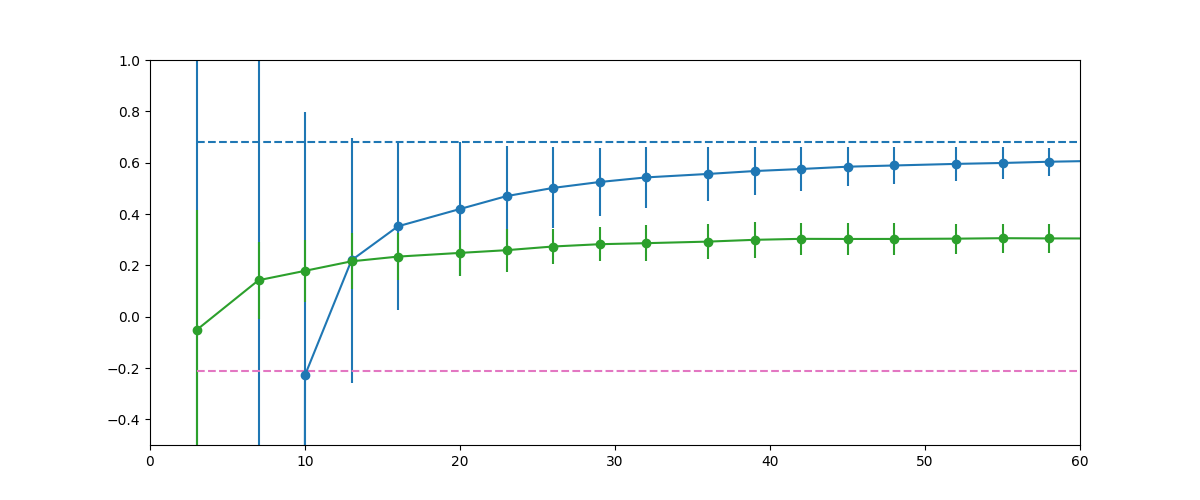

In [21]:
fig1 = plt.figure()
ax1= fig1.add_subplot(111)
x = subsample_list
ax1.set_ylim(bottom=-.5, top=1)
#ax1.scatter(number_of_gaits, fixed_decoder_scores, color='tab:olive')
ax1.plot(num_gaits, fixed_decoder_scores, '--', color='tab:pink')
ax1.errorbar(num_gaits, pca_scores_avg, yerr=pca_scores_std, fmt='-o',color='tab:blue')
ax1.errorbar(num_gaits, cca_scores_avg, yerr=cca_scores_std, fmt='-o', color='tab:green')
#ax1.errorbar(num_gaits, r_scores_avg, yerr=r_scores_std, fmt='-o', color='tab:orange')
#ax1.errorbar(num_gaits, pinv_scores_avg, yerr=pinv_scores_std, fmt='-o', color='tab:olive')
ax1.plot(num_gaits, peak, '--', color='tab:blue')


#legend11 = ['fixed decoder', 'pca decoder', 'cca aligned', 'preloaded decoder']

ax1.set_xlim(0,60)
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

#ax1.set_xlabel('Number of Gait Cycles Trained On')
#ax1.set_ylabel('VAF')
#ax1.legend(legend11, loc='lower right')
print(num_gaits[-1])
#plt.savefig('/home/diya/Documents/rat-fes/results/sfn_poster/fig5f.pdf', dpi=600)

In [18]:
pinv_scores_avg

[0.0734,
 -7.05736040609137,
 -0.02373737373737374,
 0.2883756345177665,
 0.39464285714285713,
 0.4532307692307692,
 0.4943298969072165,
 0.5232124352331607,
 0.5438020833333334,
 0.5602094240837697,
 0.5730526315789474,
 0.5831216931216932,
 0.5904255319148937,
 0.596524064171123,
 0.6019354838709677,
 0.6065405405405406,
 0.6107608695652174,
 0.6141530054644808,
 0.6176923076923077,
 0.6204419889502761,
 0.6229999999999999,
 0.6256983240223464,
 0.6275280898876404,
 0.6296610169491526,
 0.6314772727272727,
 0.6329142857142857,
 0.6346551724137931,
 0.6363005780346821,
 0.6377325581395349,
 0.638421052631579,
 0.6397058823529411,
 0.6406508875739646,
 0.6423214285714286,
 0.6432335329341319,
 0.6437349397590362,
 0.6446060606060607,
 0.6453048780487806,
 0.6460736196319019,
 0.6470987654320989,
 0.6536842105263158,
 0.6568309859154928,
 0.660378787878788,
 0.663360655737705,
 0.6640178571428571,
 0.6671568627450984,
 0.667608695652174,
 0.6691463414634146,
 0.6697222222222222,
 0.6700

# notes

cp1_path = '/home/diya/Documents/rat-fes/data/filipe_data/N5/N5_171016_No Obstacles_s.mat'
cp2_path = '/home/diya/Documents/rat-fes/data/filipe_data/N6/N6_171204_No Obstacles_s.mat'

with these two, regression is good vaf score but in practicality something seems off!



# paths

N5 
cp1_path = '/home/diya/Documents/rat-fes/data/filipe_data/N5/N5_170929_No Obstacles_s.mat'
cp2_path = '/home/diya/Documents/rat-fes/data/filipe_data/N5/N5_171001_No Obstacles_s.mat'
'N5_171016_No Obstacles_s.mat'
'N5_171130_No Obstacles_s.mat'

n6
'N6_171026_No Obstacles_s.mat'
'N6_171204_No Obstacles_s.mat'
'N6_171211_No Obstacles_s.mat'

n9
'N9_171121_No Obstacles_s.mat'  'N9_171204_No Obstacles_s.mat'  'N9_171211_No Obstacles_s.mat'  'N9_171214_No Obstacles_s.mat